# MLP
## Learning a function
In this example, we will see how we can create a simple MLP that *learns an arbitrary function*.

Afterwards, we will see how well an MLP *can generalise* and **its limits** and what can we do about them.

Finally we will take a sneak peak at **bayesian optimization** for parameters tuning.

## What we'll be using?

### Keras: the library for the neural networks
[Keras](https://keras.io/) is a python library that offers high-level APIs to Tensorflow: we will use this to build our model, using the `Sequential` model class. Since it is an MLP, we will be using `Dense` layers.

We will also use the `print_summary`, a function usefull for displaying the built model.

If you need to install it, just run in your terminal the following:
```bash
pip install keras
```

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import print_summary

Using TensorFlow backend.


### Matplotlib: the library for plottings graphs
[Matplotlib](https://matplotlib.org/) will be the library we will be using for plotting graphs.

In [2]:
import matplotlib.pyplot as plt

In [3]:
def plot(x_train, y_train, x_pred, y_pred, y_true):
    plt.plot(x_pred, y_true)
    plt.plot(x_train, y_train, "o")
    plt.plot(x_pred, y_pred)
    plt.show()

### Numpy & Sklearn: time-saver libraries
[Numpy](https://docs.scipy.org/doc/numpy/index.html) and [Sklearn](https://scikit-learn.org/stable/) are two libraries that we will be use extensively to quickly write some complex functions, such as generating and splitting the dataset.

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Utilities
We will use [tqdm](https://github.com/tqdm/tqdm) to visualize the training progress and typing to help understand which type of variables go in and out of functions.

In [5]:
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from typing import Tuple

### Resetting the random seed
To be able to reproduce the results, since some elements are initialized via random extractions, it is important to set the random seed as follows:

In [6]:
import os
import random
import tensorflow as tf

In [13]:
def set_seed(seed:int):
    """Set the random state of the various random extractions.
        seed:int, the seed to set the random state to.
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)

## Creating the dataset
In a real scenario, clearly, we would not know the analytical description of the function we would like our network to approximate, but in our example we will create a function, `black_box`, that we will pretend to not know. We will **pretend** to have only a few ($N$) datapoints, which we will use to train our MLP.

In [15]:
def black_box(x:np.ndarray)->np.ndarray:
    """Return the output for the given input of a pretended analitically unknown function.
       x:np.ndarray, input for which to determine the function values
    """
    return np.sin(x)

To visualize how our function looks like, even though usually we do not know, we can plot a few datapoints as follow, using `matplotlib`:

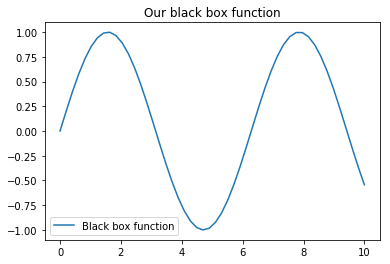

In [34]:
def plot_black_box():
    x = np.linspace(0,10)
    y = black_box(x)
    plt.plot(x,y, label='Black box function')
    
plot_black_box()
plt.title("Our black box function")
plt.legend()
plt.show()

### Sampling
Lets now suppose that we have some tool that allows us to know some output $y$ of `black_box` for some given input $x$: we will call this function `black_box_sampler`. We will also **pretend** that this function can only produce a limited number $N$ of samples.

In [35]:
def black_box_sampler(N:int, seed:int=42)->Tuple[np.ndarray, np.ndarray]:
    """Return a Tuple of N input and outputs from the black_box function.
        N:int, number of samples to return.
        seed:int=42, the number of the seed to be used to render the extraction reproducible.
    """
    set_seed(seed)
    x = np.random.uniform(low=0, high=10, size=N)
    y = black_box(x)
    return x, y

Let's now visualize what our `black_box_sampler` returns if we suppose to obtain $N=50$ samples, keeping in mind that we do not know how the function actually looks like and that these points will be everything we know about it.

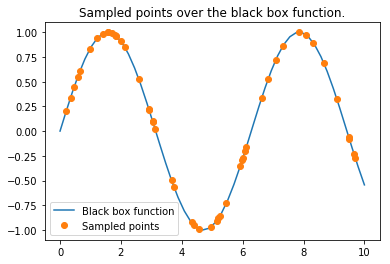

In [37]:
plot_black_box()
plt.plot(*black_box_sampler(50), "o", label='Sampled points')
plt.title("Sampled points over the black box function.")
plt.legend()
plt.show()

## Splitting the dataset: training and testing set

To train our network we will be using a portion of the sampled datapoints extracted via a random uniform distribution called **training set** and we will evaluate the obtained models using the **testing set**.

The two dataset will have size $0.7$ and $0.3$ respectively.

To split the dataset in two we will use the function `train_test_split` from the sklearn package, to which we will also set the parameter `random_state`: the extraction is randomized, but we want to be able to reproduce the results, so for every given random_state we will obtain a fixed dataset split.

In [16]:
def split_dataset(dataset:Tuple[np.ndarray, np.ndarray], seed:int)->Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return the given dataset split among training a test set for the given random seed.
        dataset:Tuple[np.ndarray, np.ndarray], 
        seed:int, 
    """
    return train_test_split(*dataset, test_size=0.3, random_state=seed)

Let's visualize the split:

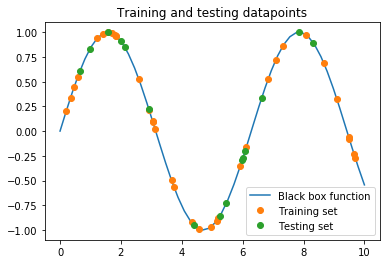

In [40]:
def plot_dataset_split(x_train, x_test, y_train, y_test):
    plot_black_box()
    plt.plot(x_train,y_train, "o", label='Training set')
    plt.plot(x_test,y_test, "o", label='Testing set')

plot_dataset_split(*split_dataset(black_box_sampler(50), 42))
plt.title("Training and testing datapoints")
plt.legend()
plt.show()

### Holdouts: what they are and why we need them.
There is a chance that, by splitting randomly the dataset, we could get really uneven training and test set: picture an extraction that by chance split the two datasets below and above $8$.

This is clearly very unlickely, but remains in the realm of possibilities. How unlickely? 

Suppose we have $100$ datapoints, uniformely distributed from $0$ to $10$, and we split the two datasets at $0.7$ and $0.3$. What is the probability that all the $70$ points of the training set $X$ are below $8$?

$$P(x<8) = \frac{8}{10}, \quad P(\forall x \in X: x<8) = {P(x<8)}^{|X|} = 1.6\cdot 10^{-7}$$

That seems very unlickely: if that quantity were meters, it would have the size of a bacterium. But still, such things can happen.

The model would have a really hard trying to predict the values in the test set, not having seen nothing similar, and the results would be awful. Would that mean that our model is always awful?

No, it would mean that the training dataset does not represent at all the test dataset. To avoid this unfortunate separation or, on the other size of the coin, an extremely fortunate one, usually the results obtain from a network are averaged across a number of **holdouts**, that is a number of datasets split with different seeds.

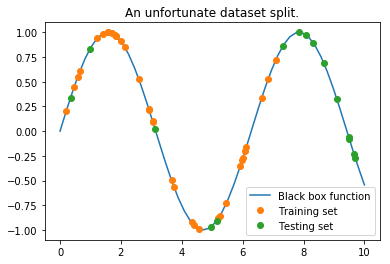

In [41]:
plot_dataset_split(*split_dataset(black_box_sampler(50), 791641))
plt.title("An unfortunate dataset split.")
plt.legend()
plt.show()

In [ ]:
def scale(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [ ]:
def generate_holdout(x:np.ndarray, y:np.ndarray, test_size:float, random_state:int):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    return (*scale(x_train, x_test), *scale(y_train, y_test))

In [ ]:
def mlp(breath:int, deapth:int):
    model = Sequential([
        Dense(1, input_shape=(1,), activation="relu"),
        *[
            Dense(breath, activation="relu") for i in range(deapth)
        ],
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer='nadam',
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    return model

In [ ]:
def fit(model, x_train, x_test, y_train, y_test, epochs, initial_epoch):
    return model.fit(
        x_train,
        y_train,
        shuffle=True,
        verbose=0,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        initial_epoch=initial_epoch
    )

In [ ]:
test_size = 0.3
validation_size = 0.1
random_state = 42
starting_epochs = 5
steps = 5
batch_size = 16
breath, deapth = 50, 5

In [ ]:
x, y = sin(30)
x_scaler, x_train, x_test, y_scaler, y_train, y_test = generate_holdout(x, y, test_size, random_state)

In [ ]:
set_seed(random_state)
model = mlp(breath, deapth)
for step in tqdm(range(steps)):
    fit(model, x_train, x_test, y_train, y_test, epochs_per_step*(step+1), epochs_per_step*step)
    x_wide = np.linspace(0,2*np.pi, num=1000).reshape(-1, 1)
    plot(
        x_scaler.inverse_transform(x_train),
        y_scaler.inverse_transform(y_train),
        x_wide,
        y_scaler.inverse_transform(model.predict(x_scaler.transform(x_wide))),
        np.sin(x_wide)
    )